In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
import gym
import numpy as np
import random as rand

class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1
        
        self.node_num = 12
        self.learning_rate = 0.0005
        self.epochs_cnt = 5
        self.model = self.build_model()        
        
        self.discount_rate = 0.95
        self.penalty = -10

        self.episode_num = 500
        
        self.moving_avg_size = 20
        
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
        self.states, self.action_matrixs, self.action_probs, self.rewards = [],[],[],[]
        
        self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size))
    
    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_actions = data
            states, action_matrix, rewards = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape:
                y_pred = self(states, training=True)
                action_probs = K.sum(action_matrix*y_pred, axis=-1)
                loss = -K.log(action_probs)*rewards

            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
    def build_model(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(1,self.action_size), name='input_action_matrixs')
        input_rewards = Input(shape=(1,self.value_size), name='input_rewards')
        
        x = (input_states)
        x = Dense(self.node_num, activation='tanh')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_rewards], outputs=out_actions)
        
        model.compile(optimizer=Adam(lr=self.learning_rate))
        
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):

            state = self.env.reset()
            self.env.max_episode_steps = 500

            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
                
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
                
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
            
        self.save_model()
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count+=1

            state_t = np.reshape(state,[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])
            
            action_prob = self.model.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD])
            
            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            
            state_next, reward, done, none = self.env.step(action)
            
            if count < 500 and done:
                reward = self.penalty 
            
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.action_matrixs.append(np.reshape(action_matrix, [1,self.action_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(reward)

            reward_tot += reward
            state = state_next
        return count, reward_tot

    def clear_memory(self):
        self.states, self.action_matrixs, self.action_probs, self.rewards = [],[],[],[] #clear memory


    def make_discount_rewards(self, rewards):
        discounted_rewards = np.zeros(np.array(rewards).shape)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_rate + rewards[t]
            discounted_rewards[t] = running_add
        
        return discounted_rewards
    
    def train_mini_batch(self):
        discount_rewards = np.array(self.make_discount_rewards(self.rewards))
        discount_rewards_t = np.reshape(discount_rewards, [len(discount_rewards),1,1])

        states_t = np.array(self.states)
        action_matrixs_t = np.array(self.action_matrixs)
        action_probs_t = np.array(self.action_probs)

        self.model.fit(x=[states_t, action_matrixs_t, discount_rewards_t], y=[action_probs_t], epochs=self.epochs_cnt, verbose=0)

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/reinforce")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()



Model: "my_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_states (InputLayer)       [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 12)        60          input_states[0][0]               
__________________________________________________________________________________________________
input_action_matrixs (InputLaye [(None, 1, 2)]       0                                            
__________________________________________________________________________________________________
input_rewards (InputLayer)      [(None, 1, 1)]       0                                            
___________________________________________________________________________________________

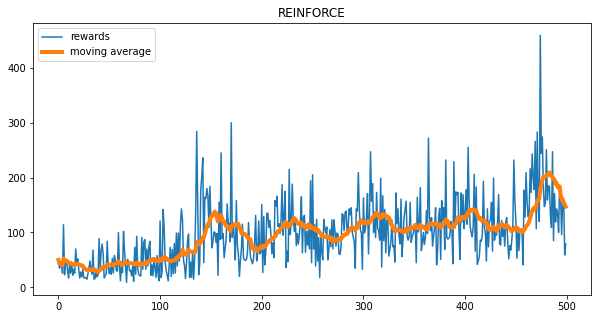

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('REINFORCE')
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

y_pred = np.array([[0.6,0.4],
                   [0.3,0.7]])
action_matrix = np.array([[1,0],
                          [0,1]])

action_probs = K.sum(action_matrix*y_pred, axis=-1)
print("*action_probs:", action_probs)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

x = tf.constant([1.0, 2.0, 3.0])

with tf.GradientTape() as tape:
    tape.watch(x)
    y = (x*x)
z = tape.gradient(y, x)
print(z)

In [ ]:
b= zip([1, 2, 3], [4, 5, 6])
c = list(b)
print(c)

In [ ]:
import numpy as np

acton_prob = [0.7, 0.3]
for i in range(10):
    d = np.random.choice(2, 1, p=acton_prob)[0]
    print(d, end=', ')

In [ ]:
a = [1,2,3,4,5]
for t in reversed(range(0, len(a))):
    print(t, end=', ')